In [1]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2019-08-30 19:54:01--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.176.72, 2600:1417:3f:4ac::e59, 2600:1417:3f:4a3::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.200.176.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs.  26%[====>               ] 208,87M  4,58KB/s    eta 1h 40m ^C


AttributeError: module 'os' has no attribute 'getwd'

In [2]:
dataset = os.path.join(os.getcwd(), "cats-and-dogs.zip")

local_zip = dataset
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()


In [2]:
print(len(os.listdir(os.path.join(os.getcwd(),'PetImages/Cat/'))))
print(len(os.listdir(os.path.join(os.getcwd(),'PetImages/Dog/'))))

# Expected Output:
# 12501
# 12501

12501
12501


In [12]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    print(os.path.join(os.getcwd(), "c_d/training/cats"))
    os.makedirs(os.path.join(os.getcwd(), "c_d/training/cats"), exist_ok=True)
    os.makedirs(os.path.join(os.getcwd(), "c_d/training/dogs"), exist_ok=True)
    os.makedirs(os.path.join(os.getcwd(), "c_d/testing/cats"), exist_ok=True)
    os.makedirs(os.path.join(os.getcwd(), "c_d/testing/dogs"), exist_ok=True)
except OSError:
    print("failed")
    pass

/media/bram/my_book/programming/onlineCourses/dlaicourse/Exercises/Exercise 5 - Real World Scenarios/c_d/training/cats


In [4]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    listdir = os.listdir(SOURCE)
    num_img = len(listdir)
    randlist = random.sample(listdir, num_img)
    num_training = int(SPLIT_SIZE * num_img)
    num_testing = num_img - num_training
    
    for i in range(0,num_training):
        img_path = os.path.join(SOURCE, randlist[i])
        if os.path.getsize(img_path) != 0:
            img_path_cp = os.path.join(TRAINING, randlist[i])
            copyfile(img_path, img_path_cp)
        else:
            print(img_path + "is not exist")
            
    for i in range(num_training, num_img):
        img_path = os.path.join(SOURCE, randlist[i])
        if os.path.getsize(img_path) != 0:
            img_path_cp = os.path.join(TESTING, randlist[i])
            copyfile(img_path, img_path_cp)
        else:
            print(img_path + "is not exist")
    
    
    
    


CAT_SOURCE_DIR = os.path.join(os.getcwd(),"PetImages/Cat/")
TRAINING_CATS_DIR = os.path.join(os.getcwd(),"c_d/training/cats/")
TESTING_CATS_DIR = os.path.join(os.getcwd(),"c_d/testing/cats/")
DOG_SOURCE_DIR = os.path.join(os.getcwd(),"PetImages/Dog/")
TRAINING_DOGS_DIR = os.path.join(os.getcwd(),"c_d/training/dogs/")
TESTING_DOGS_DIR = os.path.join(os.getcwd(),"c_d/testing/dogs/")

split_size = .9
#split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
#split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [5]:
print(len(os.listdir(TRAINING_CATS_DIR)))
print(len(os.listdir(TRAINING_DOGS_DIR)))
print(len(os.listdir(TESTING_CATS_DIR)))
print(len(os.listdir(TESTING_DOGS_DIR)))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11249
11249
1251
1251


In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    Conv2D(kernel_size = 3, filters = 16, input_shape=(150, 150,3), activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(kernel_size = 3, filters = 32, activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(kernel_size = 3, filters = 64, activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Flatten(),
    Dense(units = 512, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')    
# YOUR CODE HERE
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

W0908 14:35:32.094604 140623922648896 deprecation.py:506] From /home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0908 14:35:32.272047 140623922648896 deprecation.py:323] From /home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
TRAINING_DIR = os.path.join(os.getcwd(),"c_d/training")
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

VALIDATION_DIR = os.path.join(os.getcwd(),"c_d/testing")
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22497 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


In [8]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/

Epoch 1/15
704/704 [==============================] - 70s 100ms/step - loss: 0.5884 - acc: 0.6904 - val_loss: 0.5177 - val_acc: 0.7461
Epoch 2/15
182/704 [======>.......................] - ETA: 42s - loss: 0.4812 - acc: 0.7732

/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/bram/anaconda3/envs/dl36/lib/python3.6/site-packages/PIL/

704/704 [==============================] - 66s 94ms/step - loss: 0.4626 - acc: 0.7840 - val_loss: 0.4617 - val_acc: 0.7965
Epoch 3/15
704/704 [==============================] - 65s 93ms/step - loss: 0.3945 - acc: 0.8241 - val_loss: 0.4756 - val_acc: 0.7721
Epoch 4/15
704/704 [==============================] - 67s 96ms/step - loss: 0.3435 - acc: 0.8540 - val_loss: 0.4112 - val_acc: 0.8129
Epoch 5/15
704/704 [==============================] - 67s 95ms/step - loss: 0.2960 - acc: 0.8775 - val_loss: 0.4325 - val_acc: 0.8281
Epoch 6/15
704/704 [==============================] - 66s 94ms/step - loss: 0.2470 - acc: 0.8999 - val_loss: 0.5135 - val_acc: 0.8265
Epoch 7/15
704/704 [==============================] - 67s 95ms/step - loss: 0.2077 - acc: 0.9202 - val_loss: 0.7873 - val_acc: 0.7657
Epoch 8/15
704/704 [==============================] - 67s 95ms/step - loss: 0.1651 - acc: 0.9372 - val_loss: 0.5573 - val_acc: 0.8289
Epoch 9/15
704/704 [==============================] - 67s 96ms/step - los

Text(0.5, 1.0, 'Training and validation loss')

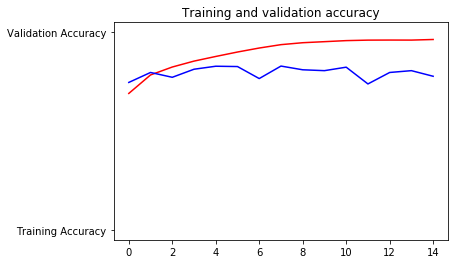

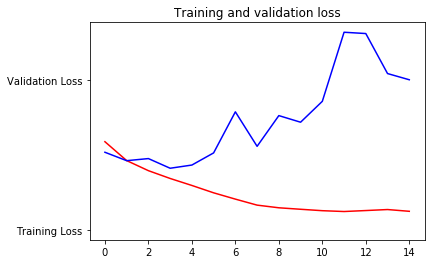

In [9]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [0]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(# YOUR CODE HERE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")